# Additional Weather EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
train = pd.read_csv('west_nile/train.csv')
weather = pd.read_csv('west_nile/weather.csv', na_values=['M', '-', ' ']) #replace 'M', '-', ' ' as null values

In [3]:
#remove all trace values from data frame
weather = weather.replace(r'\s*T', np.nan, regex=True)

In [4]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [5]:
weather.drop(["Depth",
              "Water1", "SnowFall"], axis=1, inplace=True)

In [6]:
#impute missing avg temp values with (max-min) / 2
weather['Tavg'] = weather['Tavg'].fillna((weather['Tmax'] - weather['Tmin']) / 2)

In [7]:
#impute columns with missing data <5% of dataset
def fillna_mean(df, columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())
fillna_mean(weather, ['StnPressure', 'SeaLevel', 'AvgSpeed', 'Heat', 'Cool', 'WetBulb'])

In [8]:
#function for foward fill/Last Observation Carried Foward
def front_fill(df, columns):
    for col in columns:
        df[col] = df[col].fillna(method='ffill')

In [9]:
front_fill(weather, ['PrecipTotal', 'Sunrise', 'Sunset', 'Depart', 'CodeSum'])
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)
weather['CodeSum'] = weather['CodeSum'].fillna(method='bfill')

In [10]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

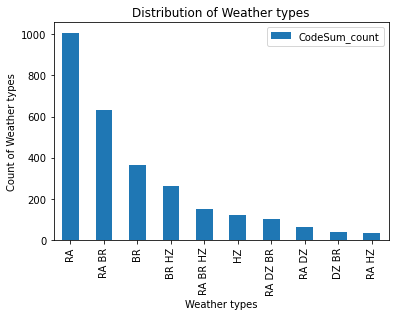

In [11]:
#Count the number weather types
code_cnt = weather.groupby('CodeSum').agg({'CodeSum': 'count'})
code_cnt.rename(columns={'CodeSum': 'CodeSum_count'}, inplace=True)
code_cnt.sort_values(by='CodeSum_count', ascending=False).head(10).plot(kind='bar');
plt.title('Distribution of Weather types');
plt.xlabel('Weather types');
plt.ylabel('Count of Weather types');

We observe that rainy days are the most frequently occuring weather types in this weather dataset

In [12]:
#erroneous entries is observed in sunset in next hr(e.g. 1860), so we correct them to appropriate format
weather['Sunset'] = weather['Sunset'].astype(int)
weather['Sunset'] = weather['Sunset'].apply(lambda x: str(x+40) if str(x)[-2:] == '60' else x).astype(int)
weather['Sunset'].head(22)

0     1849
1     1849
2     1850
3     1850
4     1851
5     1851
6     1852
7     1852
8     1853
9     1853
10    1855
11    1855
12    1856
13    1856
14    1857
15    1857
16    1858
17    1858
18    1859
19    1859
20    1900
21    1900
Name: Sunset, dtype: int64

In [13]:
weather['Date'] = pd.to_datetime(weather['Date'])

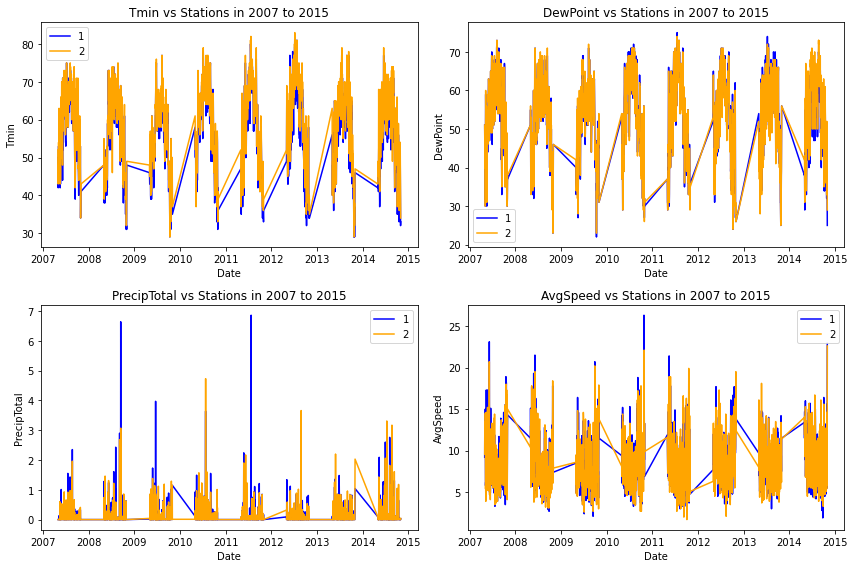

In [14]:
# Define function to create subplot grid of line plots
def plot_line_subplots(df, features):
    # Compute number of rows and columns for subplot grid
    n_rows = 2
    n_cols = 2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    
    # Flatten the axs array so we can iterate through it using a single index
    axs = axs.flatten()
    
    for i, feature in enumerate(features):
        row = i // n_cols
        col = i % n_cols
            
        sns.lineplot(data=df, x='Date', y=feature, hue='Station', palette=['blue', 'orange'], ax=axs[i])
        
        axs[i].legend()
        axs[i].set_title(f'{feature} vs Stations in 2007 to 2015')
    
    # Adjust spacing between subplots
    plt.tight_layout()

plot_line_subplots(weather, features=['Tmin', 'DewPoint', 'PrecipTotal', 'AvgSpeed'])


From the above time series plots, we can infer that there are no significant difference with respect to the weather features between both stations

Life cycle of Culex mosquito is about 7-10 days before they become adults, so we create lagged time variables of 9 days as estimation:https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html

In [15]:
rolling = weather.set_index('Date')
rolling.sort_index(inplace=True)

In [16]:
#create lagged time variables by rolling the mean and plot the time series charts
def roll(df, col):
    plt.figure(figsize=(12,8))
    plt.plot(weather[col], label=f"Default {col}")
    plt.plot(weather[col].rolling(9).mean(), label=f"9 day rolling mean of {col}")
    plt.legend()
    plt.show()

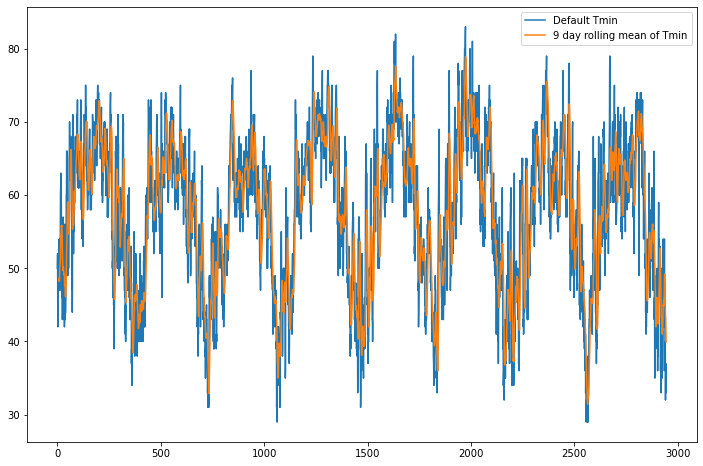

In [17]:
roll(rolling, 'Tmin')

Culex mosquitos are nocturnal animals where they feed mainly between dusk and dawn, so we create new variables to measure the length of darkness hrs:https://www.terminix.com/mosquitoes/facts/when-are-mosquitoes-active/

In [18]:
#Create new features representing no. of daylight and darkness hours
weather['daylight_hrs'] = (weather['Sunset'] - weather['Sunrise'])/100
weather['darkness_hrs'] = 24 - weather['daylight_hrs']
weather['darkness_hrs'].head()

0    9.99
1    9.99
2    9.97
3    9.97
4    9.95
Name: darkness_hrs, dtype: float64

Research has shown that relative humidity could be a possible factor in influecning the activity of Culex mosquitos, so we create this feature using dewpoint and average temperature

In [19]:
def calculate_rh(temp_f_col, dew_point_f_col):
    # Convert Fahrenheit to Celsius
    temp_c_col = (temp_f_col - 32) * 5/9
    dew_point_c_col = (dew_point_f_col - 32) * 5/9

    # Calculate RH using Celsius formula
    es = np.exp((17.625 * temp_c_col) / (243.04 + temp_c_col))
    e = np.exp((17.625 * dew_point_c_col) / (243.04 + dew_point_c_col))
    rh = (e / es) * 100

    return rh.round(2)

In [20]:
weather['rh'] = calculate_rh(weather['Tavg'], weather['DewPoint'])

## Merge train and weather dataset

In [21]:
#function to clean train dataset
def clean_train(train_data):
    return (train_data
    [['Date','Species','Trap','Latitude','Longitude','NumMosquitos','WnvPresent']]
    .assign(Date = pd.to_datetime(train_data.Date))
    .astype({'Species':'category', 'Trap':'category','NumMosquitos':'int8','WnvPresent':'int8'})
    .groupby(by=['Date','Species','Trap'])
    .agg({
        'Latitude':np.mean,
        'Longitude':np.mean,
        'NumMosquitos':np.sum, #This is to add up the number of mosquitos
        'WnvPresent':np.max,
    })
    .dropna()
    .sort_values(['Date','Trap'])
    .reset_index()
    .astype({'NumMosquitos':'int16','WnvPresent':'int8'})
    )


In [22]:
#function to select key weather features, and cleanup weather dataset
def weather_clean(df_weather):
    return (df_weather
     [['Station','Date','Tmax','Tmin','Tavg', 'Depart', 'DewPoint','CodeSum','PrecipTotal', 'daylight_hrs', 'darkness_hrs', 'rh', 'SeaLevel', 'AvgSpeed']]
     .assign(Date=pd.to_datetime(df_weather['Date']),
         Latitude=df_weather['Station'].map(lambda x:41.995 if x==1 else 41.786), # Station 1's coordinates (Lat: 41.995, Long: -87.933), Station 2's coordinates (Lat: 41.786, Long: -87.752)
         Longitude=df_weather['Station'].map(lambda x:-87.933 if x==1 else -87.752),
         Tavg=df_weather['Tavg'].map(lambda x: np.nan if x=='M' else x).ffill(),
         Depart=df_weather['Depart'].map(lambda x: np.nan if x=='M' else x).ffill(),
         PrecipTotal=df_weather['PrecipTotal'].map(lambda x: 0 if x=='  T' else x).map(lambda x: np.nan if x=='M' else x).ffill())
     .astype({'Station':'category','Tmax':'int8','Tmin':'int8','Tavg':'int8','Depart':'int8','PrecipTotal':'float32', 'DewPoint':'int8'})
     .join(df_weather['CodeSum'].str.get_dummies(sep=' ')) # Dummify the weather codes
     .drop('CodeSum', axis = 1)
    )

#function to concatenate data from station 1 and station 2
def join_stations(df_weather):
  df_station1 = df_weather[df_weather['Station']==1]
  df_station2 = df_weather[df_weather['Station']==2]
  df_station1.set_index('Date', inplace=True)
  df_station2.set_index('Date',inplace=True)
  df_weather2 = df_station1.join(df_station2, rsuffix='2')
  df_weather3 = df_weather2.rolling(9).mean()
  return df_weather3.drop(columns=['Station','Station2'])

In [23]:
#function to join train and weather data
def append_weather(df, weather_df):
    df = df.assign(Date=pd.to_datetime(df['Date']))
    weather_df = weather_df.drop(columns=['Latitude','Longitude','Latitude2','Longitude2'])
    df = df.merge(weather_df, left_on='Date', right_on='Date')
    return df

In [24]:
clean_train_df = clean_train(train)

In [25]:
weather_cleaned_joined_stations = join_stations(weather_clean(weather))

In [26]:
weather_cleaned_joined_stations.reset_index(inplace=True)

In [27]:
weather_cleaned_joined_stations.columns

Index(['Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'PrecipTotal',
       'daylight_hrs', 'darkness_hrs', 'rh', 'SeaLevel', 'AvgSpeed',
       'Latitude', 'Longitude', 'BCFG', 'BR', 'DZ', 'FG', 'FG+', 'FU', 'HZ',
       'MIFG', 'RA', 'SN', 'SQ', 'VCFG', 'Tmax2', 'Tmin2', 'Tavg2', 'Depart2',
       'DewPoint2', 'PrecipTotal2', 'daylight_hrs2', 'darkness_hrs2', 'rh2',
       'SeaLevel2', 'AvgSpeed2', 'Latitude2', 'Longitude2', 'BCFG2', 'BR2',
       'DZ2', 'FG2', 'FG+2', 'FU2', 'HZ2', 'MIFG2', 'RA2', 'SN2', 'SQ2',
       'VCFG2'],
      dtype='object')

In [28]:
weather_cleaned_joined_stations.dropna(inplace=True)

In [29]:
weather_cleaned_joined_stations.isnull().sum()

Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
PrecipTotal      0
daylight_hrs     0
darkness_hrs     0
rh               0
SeaLevel         0
AvgSpeed         0
Latitude         0
Longitude        0
BCFG             0
BR               0
DZ               0
FG               0
FG+              0
FU               0
HZ               0
MIFG             0
RA               0
SN               0
SQ               0
VCFG             0
Tmax2            0
Tmin2            0
Tavg2            0
Depart2          0
DewPoint2        0
PrecipTotal2     0
daylight_hrs2    0
darkness_hrs2    0
rh2              0
SeaLevel2        0
AvgSpeed2        0
Latitude2        0
Longitude2       0
BCFG2            0
BR2              0
DZ2              0
FG2              0
FG+2             0
FU2              0
HZ2              0
MIFG2            0
RA2              0
SN2              0
SQ2              0
VCFG2            0
dtype: int64

In [30]:
#function to convert Date to datetime format, and split into year, month, week, days of year
def datetime(df, date):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['daysofyear'] = df['Date'].dt.dayofyear

In [31]:
datetime(weather_cleaned_joined_stations, 'Date')

In [32]:
weather_cleaned_joined_stations.dtypes

Date             datetime64[ns]
Tmax                    float64
Tmin                    float64
Tavg                    float64
Depart                  float64
DewPoint                float64
PrecipTotal             float64
daylight_hrs            float64
darkness_hrs            float64
rh                      float64
SeaLevel                float64
AvgSpeed                float64
Latitude                float64
Longitude               float64
BCFG                    float64
BR                      float64
DZ                      float64
FG                      float64
FG+                     float64
FU                      float64
HZ                      float64
MIFG                    float64
RA                      float64
SN                      float64
SQ                      float64
VCFG                    float64
Tmax2                   float64
Tmin2                   float64
Tavg2                   float64
Depart2                 float64
DewPoint2               float64
PrecipTo

## EDA of Weather trends and its association withe the WNV

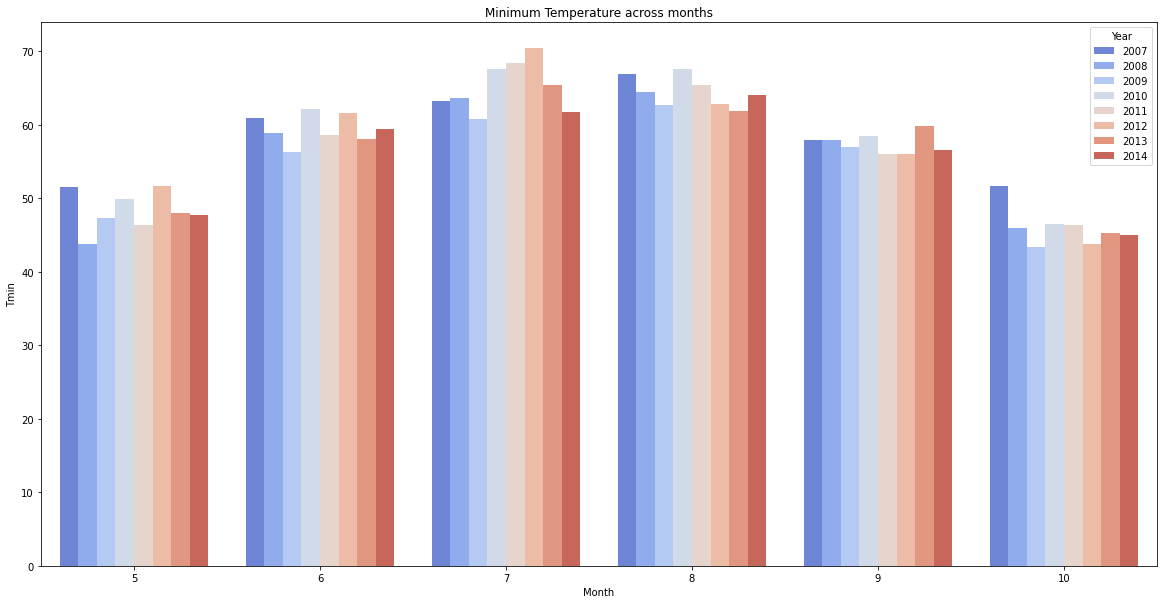

In [33]:
df = weather_cleaned_joined_stations.groupby(['Year', 'Month']).mean().reset_index()

plt.figure(figsize=(20,10))
sns.barplot(data=df, x='Month', y='Tmin', hue='Year', palette='coolwarm');
plt.title('Minimum Temperature across months');

We can see that minimum air temperatures in Chicago city peaked at 70°F in the years from 2007 - 2014, and are highest during the summer months of july and august

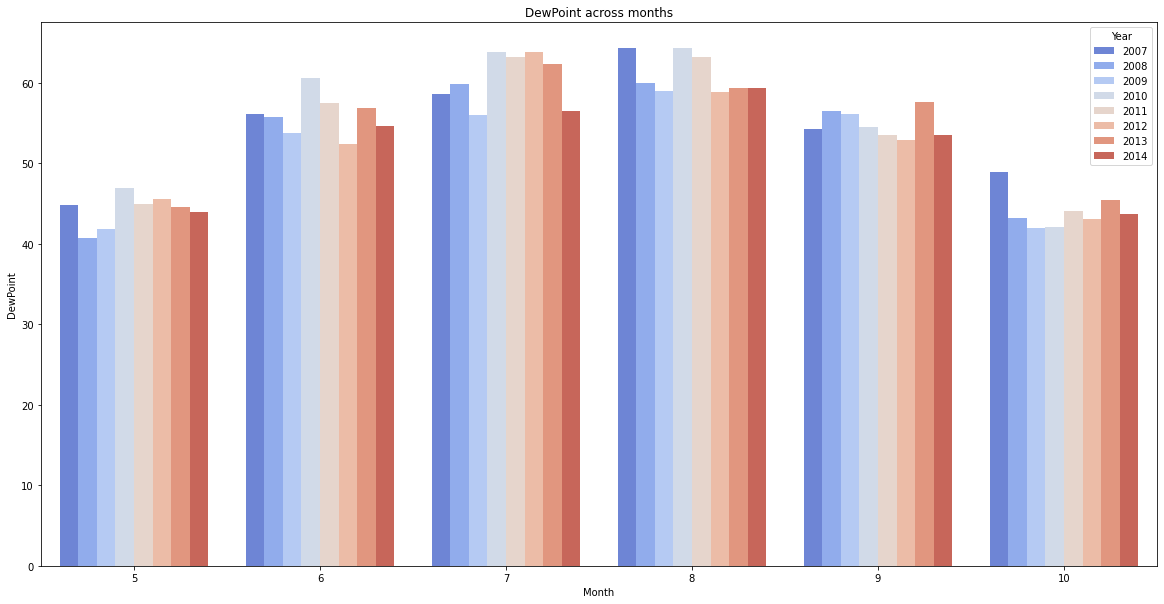

In [34]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x='Month', y='DewPoint', hue='Year', palette='coolwarm');
plt.title('DewPoint across months');

We can see that Dew Point temperatures in Chicago city peaked at 65°F in the years from 2007 - 2014, and are also the highest during the summer months of july and august

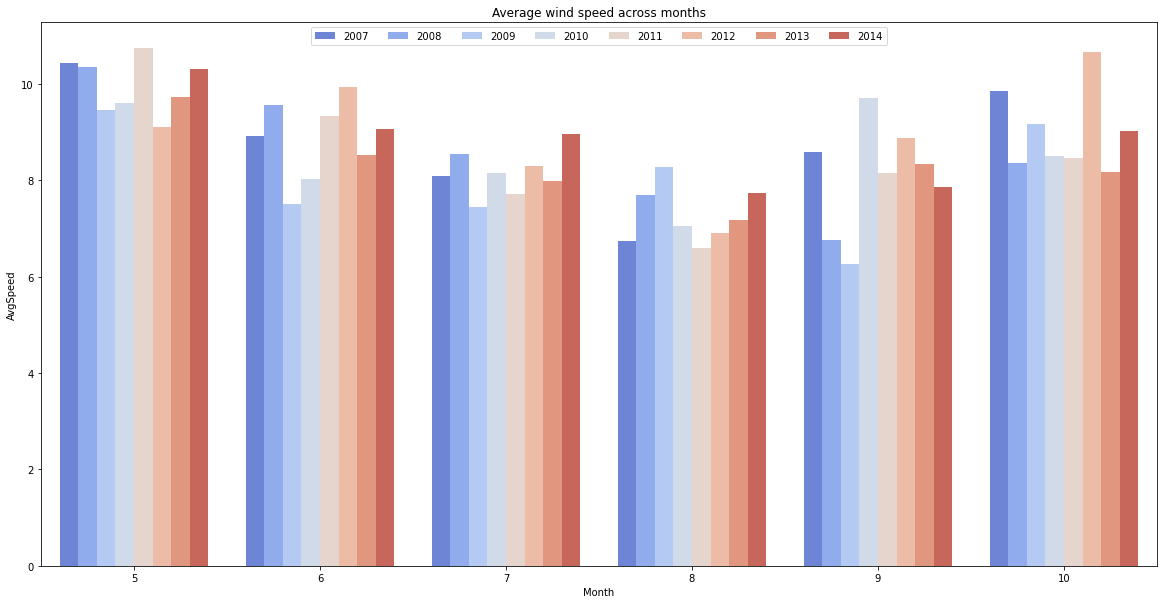

In [35]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x='Month', y='AvgSpeed', hue='Year', palette='coolwarm');
plt.legend(loc='upper center', ncol=len(df['Year'].unique()));
plt.title('Average wind speed across months');

We can see that average wind speed in Chicago city are at the lowest during the summer months of july and august in the years from 2007 - 2014

In [36]:
train_with_weather = append_weather(clean_train_df,weather_cleaned_joined_stations)

In [37]:
datetime(train_with_weather, 'Date')

In [38]:
def line_plt2(x):
    df = train_with_weather.groupby(['Year', 'WnvPresent', x])['NumMosquitos'].sum().reset_index()
    df = df[df['WnvPresent'] == 1]
    plt.figure(figsize=(20,10))
    
    sns.lineplot(data=df, x=df.loc[df['Year']==2007, x], y=df['NumMosquitos'], color='red', label='2007', marker='o', ci=None)
    sns.lineplot(data=df, x=df.loc[df['Year']==2009, x], y=df['NumMosquitos'], color='green', label='2009', marker='o', ci=None)
    sns.lineplot(data=df, x=df.loc[df['Year']==2011, x], y=df['NumMosquitos'], color='blue', label='2011', marker='o', ci=None)
    sns.lineplot(data=df, x=df.loc[df['Year']==2013, x], y=df['NumMosquitos'], color='orange', label='2013', marker='o', ci=None)
    plt.title(f'{x} vs Number of Culex Mosquitos with WNV' )

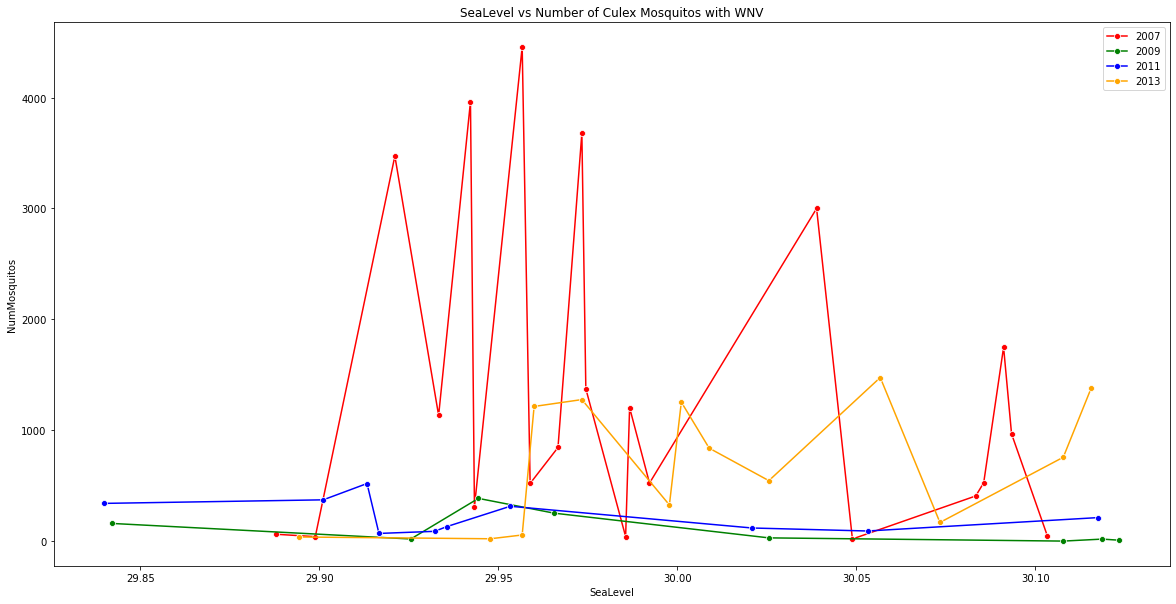

In [39]:
line_plt2('SeaLevel')

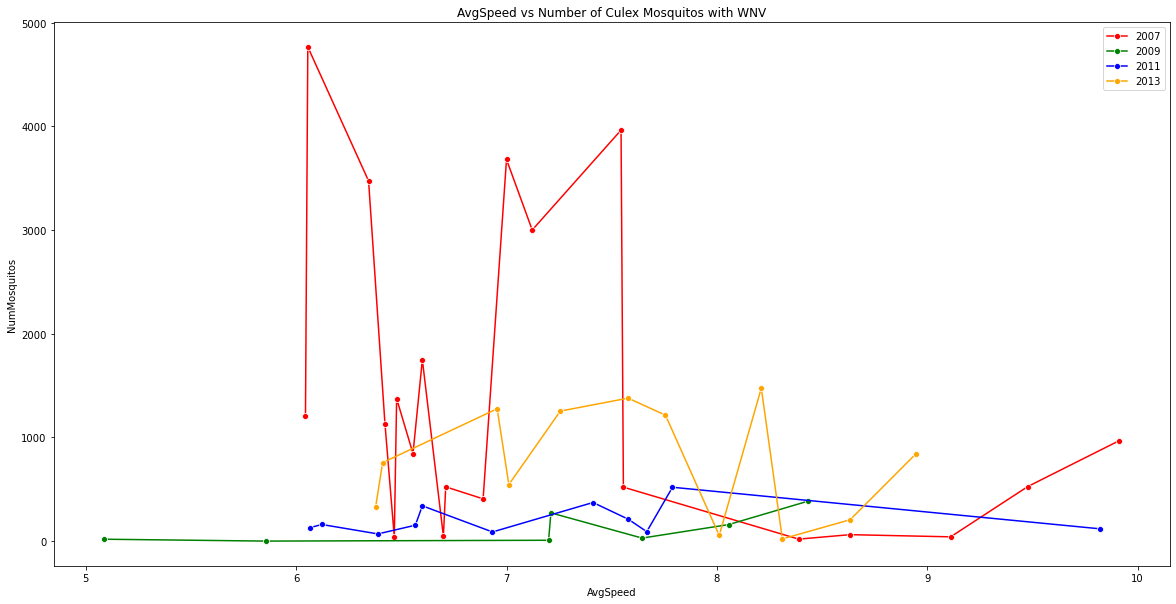

In [40]:
line_plt2('AvgSpeed')

No clear trends are observed for average wind speed and sea levels with respect to the number of mosquitos carrying the WNV

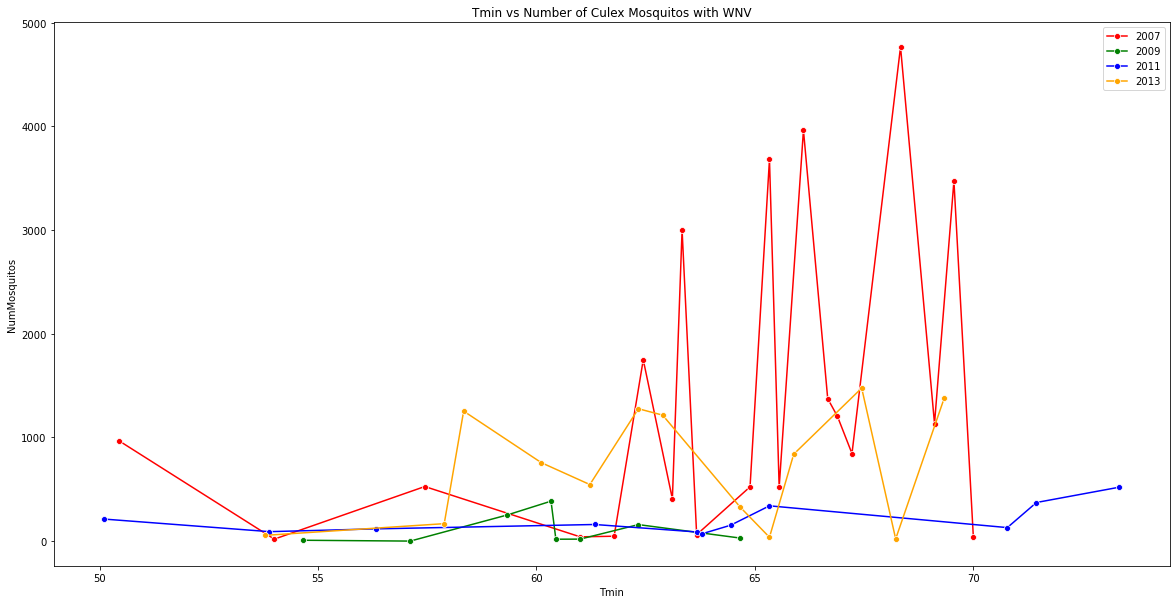

In [41]:
line_plt2('Tmin')

From this line graph, we can observe that the number of mosquitos carrying the WNV sharply increases when it crosses the threshold of 57°F, up till 70°F where it begins to dip. This could probably indicate that this temperature range could be the ideal minimum temperature where the likelihood of WNV transmission will be the highest

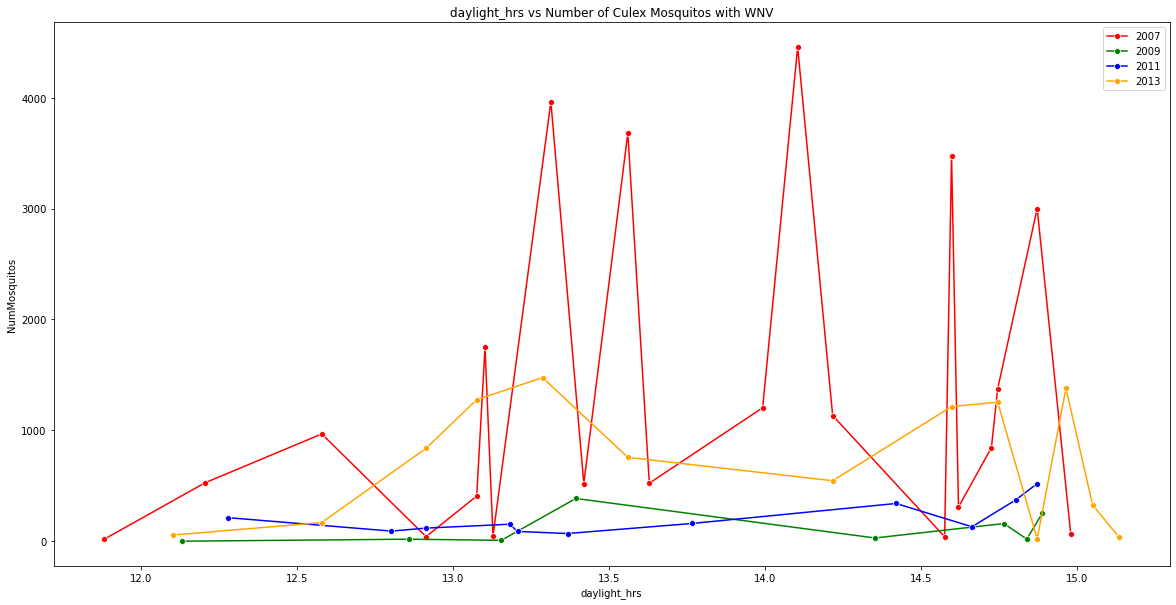

In [42]:
line_plt2('daylight_hrs')

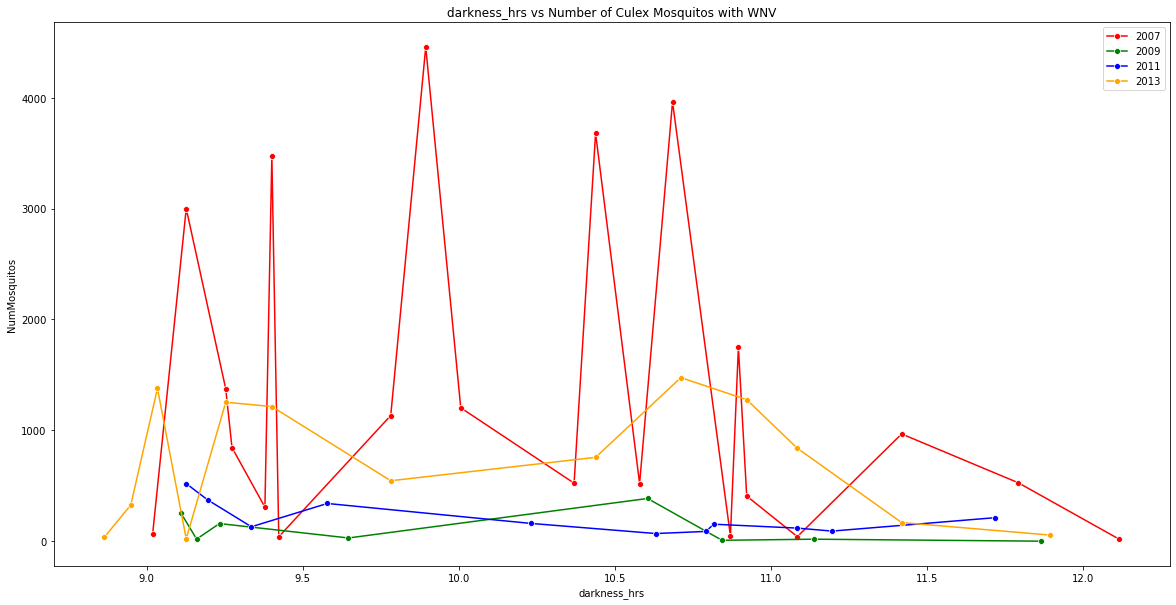

In [43]:
line_plt2('darkness_hrs')

Although culex mosquitos are nocturnal where they feed and bite between dusk and dawn based on research, we observe that the number of mosquitos carrying the WNV sharply increases with longer daylight hrs above a certain threshold(12.5hrs approx), and the reverse is observed for the length of darkness hours. 

Based on this information, we can infer that the air temperature could still be a key factor in determining the survival of culex mosquitos and also the transmission of WNV, as having longer daylight hours increases the daily minimum air temperature

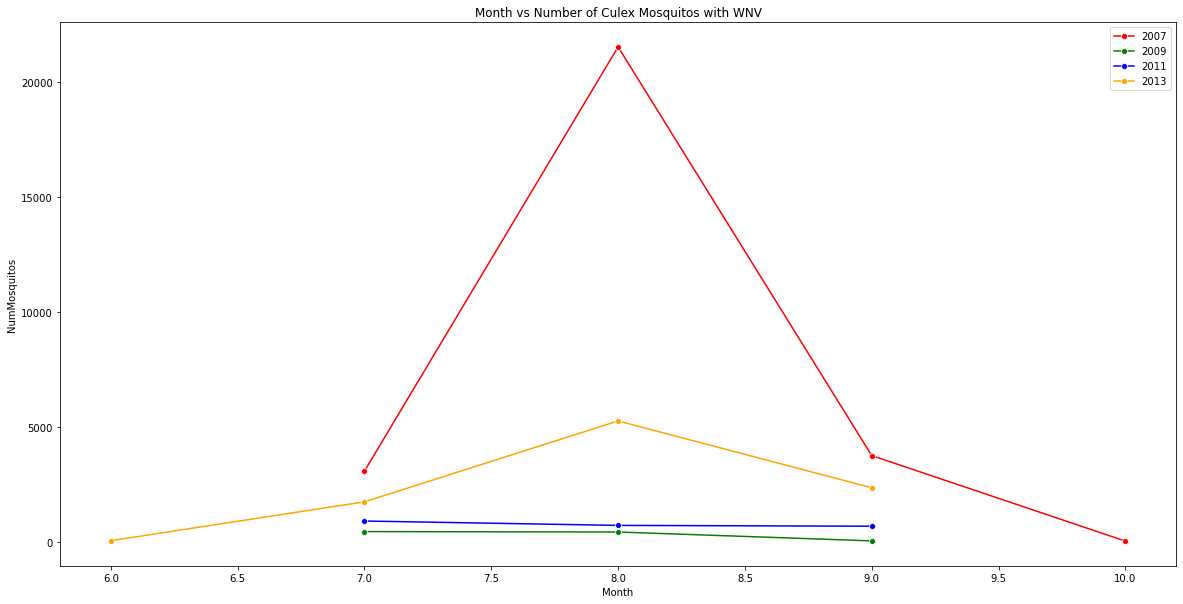

In [44]:
line_plt2('Month')

We observe that the proportion of mosquitos carrying the WNV increases during the summer months, with the number peaking in august

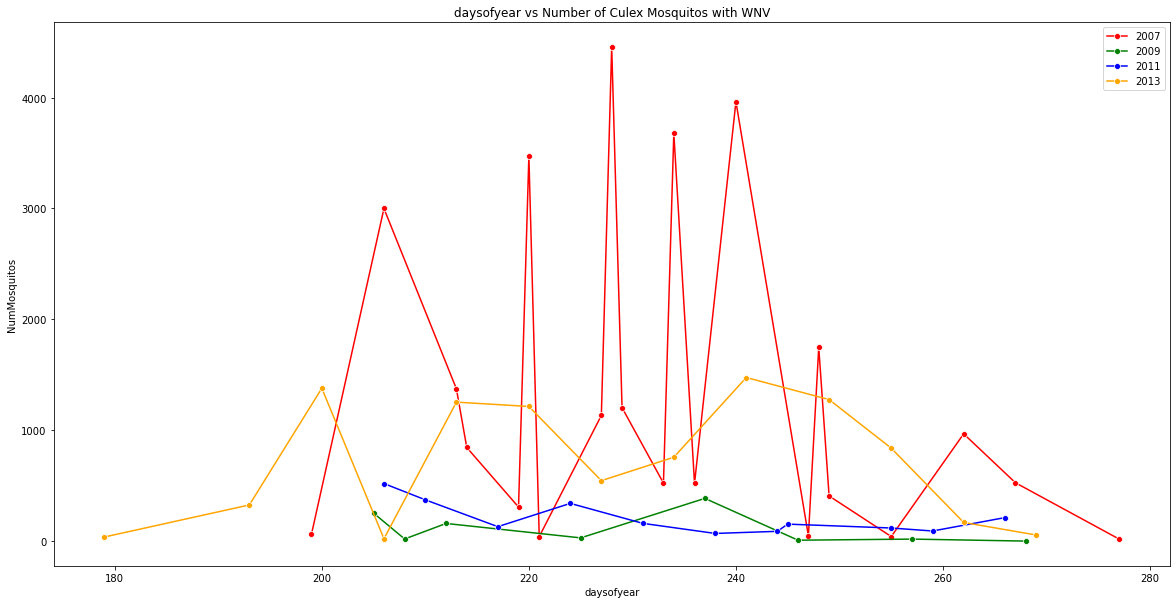

In [45]:
line_plt2('daysofyear')

The proportion of mosquitos carrying the WNV are more prominent towards the specific days in the summer months, and this could probably indicate that the life cycle of the culex mosquito and the incubation period of the WNV combined might be a strong factor towards the transmission of the WNV

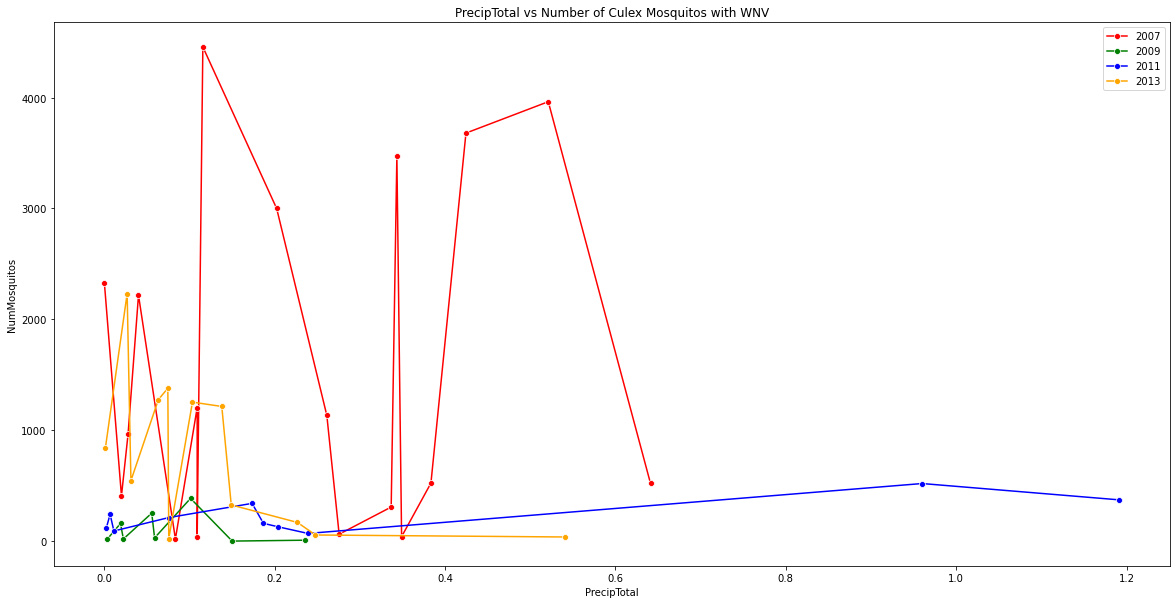

In [46]:
line_plt2('PrecipTotal')

We observe that the number of culex mosquitos carrying the WNV are the highest when precipitation such as rainfall is absent, indicating that the presence of precipitation could be impact the growth of mosquitos during the intermediate stages(larval, pupae)

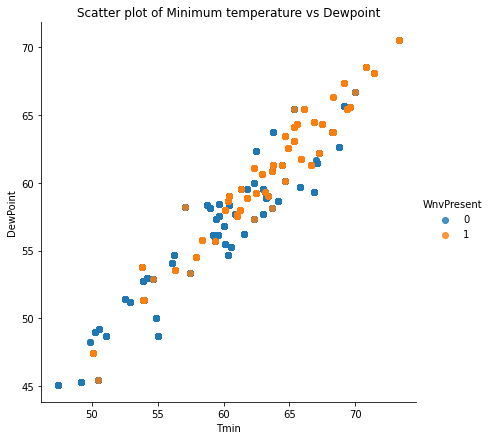

In [47]:
sns.lmplot(x='Tmin', y='DewPoint', data=train_with_weather, fit_reg=False, hue='WnvPresent', height=6);
plt.title('Scatter plot of Minimum temperature vs Dewpoint');

The likelihood of Culex mosquitos carrying the west nile virus increases as minimum temperature and dew point crosses the 60°F and 55°F threshold respectively, indicating that these features could be a strong factor for the transmission of WNV

In [48]:
#test = pd.read_csv('west_nile/test.csv')

In [49]:
#test_with_weather = append_weather(test,weather_cleaned_joined_stations)

In [50]:
#train_with_weather.to_pickle('train_w_weather.pkl')
#test_with_weather.to_csv('test_w_weather.csv', index=False)

In [51]:
#train_with_weather.to_pickle('train_w_weather.pkl')